# Project :Sentimental Analysis of Amazon Fine food Review

###  Goal: 

Given a review, determine whether the review is positive or negative review using sentimental Analysis techniques 

### Project Description:
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~600,000 reviews. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.It is expensive to check each and every review manually and label its sentiment. So The better way is to rely on machine learning for that. In this case study, we will focus on the fine food review data set on amazon which is available on Kaggle.

 
#### Data Contents:

* 568,454 reviews
* 256,059 users
* 74,258 products
* 260 users with > 50 reviews

### Details about data
1. Product Id: Unique identifier for the product
2. User Id: unique identifier for the user
3. Profile Name: Profile name of the user
4. Helpfulness Numerator: Number of users who found the review helpful
5. Helpfulness Denominator: Number of users who indicated whether they found the review helpful or not
6. Score: Rating between 1 and 5
7. Time: Timestamp
8. Summary: Summary of the review
9. Text: Review

### Importing the Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

np.random.seed(7)
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


### Load the dataset 

In [2]:
Reviews_df = pd.read_csv('Reviews.csv',nrows=25000)
Reviews_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
24995,24996,B0078Y6OX8,A2O8ULU9VP1Y3U,fawilson,1,1,5,1290556800,So Flavorful!!!!,I absolutely love the flavor of this coffee. ...
24996,24997,B0078Y6OX8,A35A03F0CMFVP6,theresa Clune,1,1,2,1290211200,not worth the money vey weak,This was a very disappointing coffee. It is v...
24997,24998,B0078Y6OX8,A38ETR815F3B2Y,newcoffeefan,1,1,5,1289520000,One taste and you are converted!,This is the best coffee flavor I have tried in...
24998,24999,B0078Y6OX8,AGKVGP6PQ5ZO,Connie Rogers,1,1,5,1289433600,Excellent,"If your looking for a good flavored coffee, th..."


## Exploratory Data Analysis

### 1.Converting the score values to positive or negative

Here ,We could used a column name Score.The rating above 4 is considered as positive review.The rating of 1 or 2 is 
considered as a negative review where as review of rating 3 is considered neutral
and this type of reviews are ignored from our analysis. This is an approximate and proxy way of determining
the polarity (positivity/negativity) of a review.

#### Distribution of Ratings

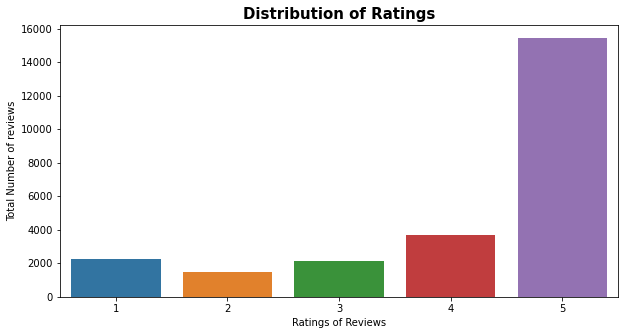

In [3]:
plt.figure(figsize=(10,5))
sns.countplot(Reviews_df['Score'])
plt.title("Distribution of Ratings", fontweight='bold', fontsize=15)
plt.xlabel("Ratings of Reviews")
plt.ylabel("Total Number of reviews")
plt.show();

On analysis,it shows that the dataset contains more positive reviews compared to negative reviews.
Therefore,will assign all data points above rating 3 as positive and below as negative rating for the reviews

In [4]:
#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
Reviews_df['Sentiment_Value'] = Reviews_df['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')


#Creating the new column which stores "Positive" as 1 and "Negative " as 0
Reviews_df['Target'] = Reviews_df['Sentiment_Value'].apply(lambda x : 1 if x == 'Positive' else 0)


### Distribution of Postive and Negative reviews in a bar graph

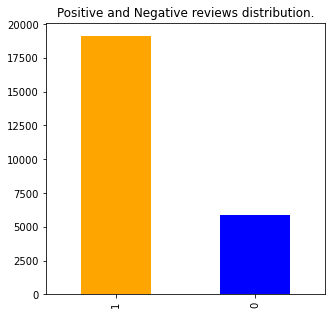

In [5]:
#Distribution of Postive and Negative reviews in a bar graph
Reviews_df["Target"].value_counts().plot(kind='bar',color=['orange','blue'],title='Positive and Negative reviews distribution.',figsize=(5,5))

 From the graph,it depicts that its an imbalanced dataset for classification.

### 3. Handle Missing values

In [6]:
Reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      25000 non-null  int64 
 1   ProductId               25000 non-null  object
 2   UserId                  25000 non-null  object
 3   ProfileName             25000 non-null  object
 4   HelpfulnessNumerator    25000 non-null  int64 
 5   HelpfulnessDenominator  25000 non-null  int64 
 6   Score                   25000 non-null  int64 
 7   Time                    25000 non-null  int64 
 8   Summary                 25000 non-null  object
 9   Text                    25000 non-null  object
 10  Sentiment_Value         25000 non-null  object
 11  Target                  25000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 2.3+ MB


From the above result,it shows that the dataset don't have any null values as its the first step of data cleaning to predict the results more efficiently.Next we need to remove the duplicates if the dataset contains to avoid reduduncy of the data

 ### 4. Data Cleaning: Deduplication

* 1.The dataset contains many duplicate entries of reviews.So to overcome the unbaised results we are deduplicating the rows 
  based  on UserId','ProfileName','Time' and sorting the dataset based on productId before deduplication to reduce the    redundancy
* 2.The dataset contains the entries such that values in HelpfulnessNumerator is higher than the values in HelpfulnessDenominator as its practically not possible
* 3.Helpfulness Numerator: Number of users who found the review helpful
    Helpfulness Denominator: Number of users who indicated whether they found the review helpful or not
* 4.On analysis, we found that for different products the same review is given by the same user at the same time. Practically it doesn’t make sense. So we will keep only the first one and remove other duplicates.

In [7]:
#Sorting data according to ProductId in ascending order
df_sa=Reviews_df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Dropping the duplicates 
df_sa=df_sa.drop_duplicates(subset=['UserId','ProfileName','Text','Time'],keep='first')
df_sa.tail(3)
#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
df_sa=df_sa[df_sa.HelpfulnessNumerator <= df_sa.HelpfulnessDenominator]

### Analysis of Dataset after datacleaning

In [8]:
#Calculating the remaining data after datacleaning
print("\npercentage of remaining data")
retained_per = (df_sa['Sentiment_Value'].size*1.0)/(Reviews_df['Sentiment_Value'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

print('------------------------------------------------------------------------------------------\n')
# Size of Data Set after removing duplicate values
print('New data set size-',df_sa.shape)
print("\n\nThe shape of the dataset after deduplication : {}".format(df_sa.shape))
print("The number of positive and negative reviews after the deduplication.")
print(df_sa["Sentiment_Value"].value_counts())


percentage of remaining data
Percentage of redundant data removed : 3.304000000000002
Percentage of original data retained : 96.696
------------------------------------------------------------------------------------------

New data set size- (24174, 12)


The shape of the dataset after deduplication : (24174, 12)
The number of positive and negative reviews after the deduplication.
Positive    18559
Negative     5615
Name: Sentiment_Value, dtype: int64


From the above results,the positive reviews are larger in number when compared to negative reviews,
So to maintain the balance,we are dropping the 170k positive reviews for easy computation and processing of data.After our preprocessing, data got reduced from 568454 to 352783.ie, about approx 65% of the data is remaining. Now let's drop some more data so the model performs better with balanced dataset rather than imbalance dataset. 

In [9]:
#Data set sorting based on sentiment polarity and deleting positive values to balance Dataset
df_sort=df_sa.sort_values(by='Sentiment_Value')
df_dropped_last_n = df_sort.iloc[:-170000]
#df_dropped_last_n

#Display information about the dataset after the removal of postive data.
print("\nThe shape of the data matrix of balanced data".format(df_dropped_last_n.shape))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(df_dropped_last_n["Sentiment_Value"].value_counts())


The shape of the data matrix of balanced data
The number of positive and negative reviews after the removal of duplicate data.
Series([], Name: Sentiment_Value, dtype: int64)


Now,we can see that dataset is comparatively balance and also overcomes the baised results..After our preprocessing, data got reduced from 568454 to 182783. Now let's drop some more data so the model performs better with balanced dataset rather than imbalance dataset

Text(0, 0.5, 'Reveiw classification')

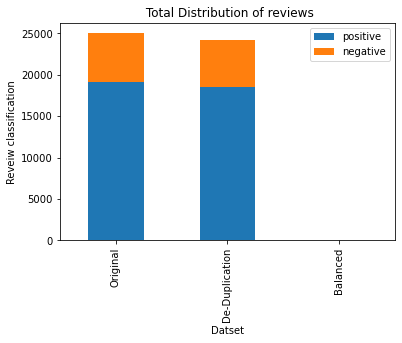

In [10]:
pos_1=Reviews_df["Sentiment_Value"].value_counts().get(key ='Positive')
pos_2=df_sa["Sentiment_Value"].value_counts().get(key ='Positive')
pos_3=df_dropped_last_n["Sentiment_Value"].value_counts().get(key ='Positive')
neg_1=Reviews_df["Sentiment_Value"].value_counts().get(key ='Negative')
neg_2=df_sa["Sentiment_Value"].value_counts().get(key ='Negative')
neg_3=df_dropped_last_n["Sentiment_Value"].value_counts().get(key ='Negative')

plotdata = pd.DataFrame({
    "positive":[pos_1, pos_2,pos_3],
    "negative":[neg_1, neg_2,neg_3],
 }, 
    index=["Original", "De-Duplication" ,"Balanced"]
)
plotdata.head()

plotdata.plot(kind='bar', stacked=True)

plt.title(" Total Distribution of reviews")
plt.xlabel("Datset")
plt.ylabel("Reveiw classification")

From the above graph,we are analysis the three stages of data distribution of positive and negative reviews 
after deduplication and dropping the rows.

## Data Preprocessing

Need to preprocess the reviews text for analysis and to make prediction .
* 1.It invovles removal of html tag,numbers associated with words,repeated characters,url,special characters etc which are 
    defined under data_preprocess()
* 2.Need to remove stop words
* 3.Need to implement stemming to remove suffixes using Snowball Stemmimg technique as its is more aggressive 
* 4.Storing all the positive and negative reviews in the different lists



In [11]:
def data_preprocess(sentence):
    #Remove words with numbers 
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    #Remove clean html tags from a sentence
    pattern = re.compile('<.*?>')
    sentence = re.sub(pattern,' ',sentence)
    #Remove words having three consecutive repeating characters.
    sentence  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    #Remove URL from sentences.
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    #Keep only words containing letters A-Z and a-z and remove all punctuations, special characters etc
    sentence  = re.sub('[^a-zA-Z]',' ',sentence)
    return (sentence)

### Stemming and Removal of stopwords

In [12]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
#print("default_stopwords:",default_stopwords)
remove_not = set(['no', 'nor', 'not'])
#print("--------------------------------------------------------------------------------------------------------------------")
defined_stopwords = default_stopwords - remove_not
print("defined_stopwords:\n",defined_stopwords)

defined_stopwords:
 {'some', 'can', "couldn't", 'has', 'own', 'at', 'haven', 'they', 'there', 'once', 'into', 'hasn', "you're", 'of', 'was', 'other', 'them', "wouldn't", 'ma', 'if', "wasn't", 'should', "you've", 'to', 'hers', 'until', 'am', 'did', 'y', "needn't", "weren't", "hadn't", 'll', 'during', 'too', 'about', 's', 'you', 'any', 'him', 'then', 'such', 'just', 'were', "aren't", 'doing', 'after', 'off', "didn't", 'i', 'does', 'their', 'ourselves', "should've", 'needn', 'few', 'shan', 'whom', 'herself', 'theirs', 'be', "mustn't", 'who', 'where', 'which', 'in', 'is', 'my', 'above', 't', 'it', 'themselves', 'had', 'by', 'between', 'or', 're', "shouldn't", 'each', 'here', 'when', 'most', 'than', 'shouldn', 'on', 'now', 'yours', 'd', 'mightn', 'and', 'all', 'weren', "doesn't", 'but', 'doesn', 'with', 'its', 'don', 'isn', 'while', 'an', 'up', 'will', 'both', 'these', 'm', 'o', "she's", 'having', 'this', 'against', 'himself', 'have', 'from', 'again', "mightn't", 'she', "isn't", 'further', 


###Convert all the words to lower case and replace the contraction words

In [13]:
import re

# Convert all the words to lower case and replace the contraction words
def replace_words(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                          
    #Converting 123000000 to 123m
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    #converting 123000 to 123k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

### Distribution of Stemmed word length

In [14]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
total_words = []
#List all the processed reviews
preprocessed_reviews = [] 
#list all the relevant words from Positive reviews
all_positive_words=[] 
#list all the relevant words from Negative reviews
all_negative_words=[] 
 
#Iterate through the list of reviews and check if a given review belongs to the positive or negative 
count=0  
string=' '    
stemed_word=' '

for review in tqdm(df_dropped_last_n['Text'].values):
    filtered_sentence=[]
    review = data_preprocess(review)
  
 
    
    for cleaned_words in review.split():   
        if((cleaned_words not in defined_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)
           
            filtered_sentence.append(stemed_word)
             #List of all the relevant words from Positive reviews
            if (df_dropped_last_n['Sentiment_Value'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word)
            #List of all the relevant words from Negative reviews
            if(df_dropped_last_n['Sentiment_Value'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) 
        else:
            continue
    
    review = " ".join(filtered_sentence) #Final string of cleaned words 
    #print("After review:",review)
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    #print("preprocessed_reviews:",preprocessed_reviews)
    count+=1

total_words = list(set(total_words))
#print("total_words:",total_words)   
#print(count(total_words))
#list all the length of words
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)


#print("------------------------------------------------------------------------------------------------------------------")
#print("length_word:",dist)


0it [00:00, ?it/s]
0it [00:00, ?it/s]


Text(0, 0.5, 'Number of Words')

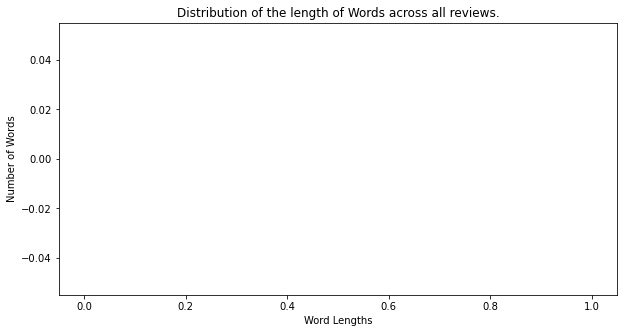

In [15]:
# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(10,5))
plt.hist(dist, color = 'orange', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

To bulid good model,we are replacing the contraction words with meaning full word and 
converting all the characters to lowercase .From the graph,We can see that Words which has length range between 2 to 15 are more and words which has length greater than 15 are few so will consider the words whose length is greater than 2 and less than 16.

### Visualization of Positive words and negative words from the reviews after data processing using word cloud

Word cloud is a technique for visualising frequent words in a text where the size of the words represents their frequency.
A word cloud (also called tag cloud or weighted list) is a visual representation of text data. Words are usually single words, and the importance of each is shown with font size or color. Python fortunately has a wordcloud library allowing to build them.


#### Positive review WordCloud

In [16]:
from wordcloud import WordCloud
#plotting all the posituve words
positive_string=(" ").join(all_positive_words)
wordcloud = WordCloud(width = 1000, height = 500).generate(positive_string)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

#### Negative review WordCloud

In [ ]:
from wordcloud import WordCloud
#plotting all the negative words
negative_string=(" ").join(all_negative_words)
wordcloud = WordCloud(width = 1000, height = 500).generate(negative_string)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

### Processing review Texts

In [ ]:
  #Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
df_dropped_last_n['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))
df_dropped_last_n.head(3)

In [ ]:
#Calculating the percentage of Positive and negative words
value_count=df_dropped_last_n['Target'].value_counts()
value_count
print("{}% data having positive reviews".format(round(value_count[1]/df_dropped_last_n.shape[0]*100,2)))
print("{}% data having negative reviews".format(round(value_count[0]/df_dropped_last_n.shape[0]*100,2)))#

### Split the dataset

To train and test model,we are splitting the dataset to 70% for training and 30% for testing the dataset

In [ ]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = df_dropped_last_n['CleanedText']
y = df_dropped_last_n['Target']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)


##  Feature Extraction: Bag of Words

 Word Embedding is a technique to convert words to vectors.The Bag of Words model is the simplest form of text representing a sentence as a a string of numbers.It considers a sparse vector.The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents
 
Suppose we have M number of  reviews in our dataset and we want to convert the vectors to  vectors representation. We can use BOW as a method to do this.It creates a dimension for each of the unique word in the data corpus and then it counts how many number of times a word is present in a review. And then this number is placed under that word for a corresponding review. We will get a Sparse Matrix representation for all the worods inthe review.



In [ ]:
bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()
print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

In [ ]:
#  function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))
    #sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

### 1.XGBOOST On BagOfWords Features

In [ ]:
xg_best_est = XGBClassifier(n_estimators = 120,max_depth=15)
xg_best_est = xg_best_est.fit(X_train_bow,y_train)
y_predict = xg_best_est.predict(X_test_bow)
train_fpr_xg_bow, train_tpr_xg_bow, thresholds = roc_curve(y_train, xg_best_est.predict_proba(X_train_bow)[:,1])
test_fpr_xg_bow, test_tpr_xg_bow, thresholds = roc_curve(y_test, xg_best_est.predict_proba(X_test_bow)[:,1])


### Performance Metric:ROC , AUC ,Confusion Matrix

In [ ]:
plt.grid(True)
plt.plot(train_fpr_xg_bow, train_tpr_xg_bow, label="train AUC ="+str(auc(train_fpr_xg_bow, train_tpr_xg_bow)))
plt.plot(test_fpr_xg_bow, test_tpr_xg_bow, label="test AUC ="+str(auc(test_fpr_xg_bow, test_tpr_xg_bow)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_xg_bow, train_tpr_xg_bow)))
print('Area under test roc {}'.format(auc(test_fpr_xg_bow, test_tpr_xg_bow)))
plot_confusion_matrixes(xg_best_est,X_train_bow,y_train,X_test_bow,y_test)

From the graph,we can analyse that Xgboosting with the Bag of words model is slightly overfitting.So we tried training and testing on various classifiers

# Top 20 Features

In [ ]:
top_words= xg_best_est.feature_importances_
features = bow_features
top_words = pd.DataFrame(top_words,columns=['coef'],index=features)
top = top_words.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))

### Performace Metric:Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(xg_best_est, X_test_bow, y_test, cv=10, scoring='accuracy')
accuracy.mean()

### To print false predicted values

In [ ]:
results = pd.DataFrame()
results['actual'] = y_test 
results['prediction'] = y_predict
print(results[results['actual']!=results['prediction']])


## 2.SVM Classifier on Bag of Words feature

In [ ]:
from sklearn.linear_model import SGDClassifier
svm_opt = SGDClassifier(alpha=0.001) 
svm_opt.fit(X_train_bow,y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_bow,y_train)
train_fpr_svm_op, train_tpr_svm_op, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_bow)[:,1])
test_fpr_svm_op, test_tpr_svm_op, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

### Performance Metric:ROC , AUC ,Confusion Matrix

In [ ]:

plt.grid(True)
plt.plot(train_fpr_svm_op, train_tpr_svm_op, label="train AUC ="+str(auc(train_fpr_svm_op, train_tpr_svm_op)))
plt.plot(test_fpr_svm_op, test_tpr_svm_op, label="test AUC ="+str(auc(test_fpr_svm_op, test_tpr_svm_op)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_svm_op, train_tpr_svm_op)))
print('Area under test roc {}'.format(auc(test_fpr_svm_op, test_tpr_svm_op)))
plot_confusion_matrixes(svm_opt,X_train_bow,y_train,X_test_bow,y_test)

From the graph,we can analyse that SVM with the Bag of words model performs better than xgboosting but still it is slightly overfitting.

### Performace Metric:Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(svm_opt, X_test_bow, y_test, cv=10, scoring='accuracy')
accuracy.mean()

## Feature Extraction:TF-IDF Vectorization

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
tfidf_features = vectorizer.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## 3. Navie Bayes on TFIDF Vectorization

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_tfidf,y_train)
train_fpr_naive_opt, train_tpr_naive_opt, thresholds = roc_curve(y_train, naive_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr_naive_opt, test_tpr_naive_opt, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_tfidf)[:,1])

### Performance Metric:ROC , AUC ,Confusion Matrix

In [ ]:
plt.grid(True)
plt.plot(train_fpr_naive_opt, train_tpr_naive_opt, label="train AUC ="+str(auc(train_fpr_naive_opt, train_tpr_naive_opt)))
plt.plot(test_fpr_naive_opt, test_tpr_naive_opt, label="test AUC ="+str(auc(test_fpr_naive_opt, test_tpr_naive_opt)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_naive_opt, train_tpr_naive_opt)))
print('Area under test roc {}'.format(auc(test_fpr_naive_opt, test_tpr_naive_opt)))

plot_confusion_matrixes(naive_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)

From the AUC ROC graph,the naive bayes model with tfidf vectorization also a slighlty overfitting  model  but performs better than Bag of words feature extraction

### Performace Metric:Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(naive_opt, X_test_tfidf, y_test, cv=10, scoring='accuracy')
accuracy.mean()

## Feature Extraction: Word2Vec 

Its is the most powerful technique which takes sematic meaning into consideration.It is one of the type of NLP 
which can detect synonyms and suggect additional words for partial sentences after training.It considers a dense vectors

In [ ]:
# preprocessed_reviews = X_train.values
# train_sentence = [rev.split() for rev in preprocessed_reviews]
# # min_count = 5 considers only words that occured atleast 5 times
# # size = length of vector
# w2v_model_train = Word2Vec(train_sentence,min_count=5,vector_size=50, workers=4)
# w2v_words = list(w2v_model_train.wv.key_to_index)

### Average Word2Vec

In [ ]:
# #convert Train dataset to vectors
# train_reviews = X_train.values
# train_sentence = [rev.split() for rev in train_reviews]

# sent_vectors_train = []
# for sent in tqdm(train_sentence):
#     sent_vec = np.zeros(50)
#     cnt_words = 0
#     for word in sent:
#         if word in w2v_words:
#             vector = w2v_model_train.wv[word]
#             sent_vec += vector
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors_train.append(sent_vec)

# print(len(sent_vectors_train))
# print(len(sent_vectors_train[0]))

# #convert Test dataset to vectors
# test_reviews = X_test.values
# test_sentence = [rev.split() for rev in test_reviews]

# sent_vectors_test = []
# for sent in tqdm(test_sentence):
#     count = 0
#     sent_vec = np.zeros(50)
#     for word in sent:
#         if word in w2v_words:
#             vector = w2v_model_train.wv[word]
#             sent_vec += vector
#             count += 1
            
#     if count != 0:
#         sent_vec /= count
#     sent_vectors_test.append(sent_vec)

# print(len(sent_vectors_test))
#print(len(sent_vectors_test[0]))

In [ ]:
# X_train_avgw2v = np.array(sent_vectors_train)
# X_test_avgw2v = np.array(sent_vectors_test)
# print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
# print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))

# SVM with Avgword2vec 

In [ ]:
# from sklearn.linear_model import SGDClassifier
# svm_opt_w2v = SGDClassifier(alpha=0.001) 
# svm_opt_w2v.fit(X_train_avgw2v,y_train)
# best_est_w2v = CalibratedClassifierCV(base_estimator=svm_opt_w2v)
# best_est_w2v = best_est_w2v.fit(X_train_avgw2v,y_train)
# train_fpr_svm_w2v, train_tpr_svm_w2v, thresholds = roc_curve(y_train, best_est_w2v.predict_proba(X_train_avgw2v)[:,1])
# test_fpr_svm_w2v, test_tpr_svm_w2v, thresholds = roc_curve(y_test, best_est_w2v.predict_proba(X_test_avgw2v)[:,1])

# Performance Metric:ROC , AUC ,Confusion Matrix

In [ ]:

# plt.grid(True)
# plt.plot(train_fpr_svm_w2v, train_tpr_svm_w2v, label="train AUC ="+str(auc(train_fpr_svm_w2v, train_tpr_svm_w2v)))
# plt.plot(test_fpr_svm_w2v, test_tpr_svm_w2v, label="test AUC ="+str(auc(test_fpr_svm_w2v, test_tpr_svm_w2v)))
# plt.legend()
# plt.xlabel("fpr")
# plt.ylabel("tpr")
# plt.title("ROC CURVE FOR OPTIMAL K")
# plt.show()

# #Area under ROC curve
# print('Area under train roc {}'.format(auc(train_fpr_svm_w2v, train_tpr_svm_w2v)))
# print('Area under test roc {}'.format(auc(test_fpr_svm_w2v, test_tpr_svm_w2v)))
# plot_confusion_matrixes(svm_opt_w2v,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

From the AUC ROC graph,the SVM model with avgword2vec vectorization produces slight overfitting  model and SVM classifier on Bag of words feature extraction performs equally good.

### Performace Metric:Cross-Validation

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(svm_opt_w2v, X_test_avgw2v, y_test, cv=10, scoring='accuracy')
accuracy.mean()

## 4.Random Forest on Tfidf feature

In [ ]:
best_est_rf = RandomForestClassifier(n_estimators = 120,max_depth=30)
best_est_rf = best_est.fit(X_train_tfidf,y_train)
train_fpr_est_rf, train_tpr_est_rf, thresholds = roc_curve(y_train, best_est_rf.predict_proba(X_train_tfidf)[:,1])
test_fpr_est_rf, test_tpr_est_rf, thresholds = roc_curve(y_test, best_est_rf.predict_proba(X_test_tfidf)[:,1])

### Performance Metric:ROC , AUC ,Confusion Matrix

In [ ]:
plt.grid(True)
plt.plot(train_fpr_est_rf, train_tpr_est_rf, label="train AUC ="+str(auc(train_fpr_est_rf, train_tpr_est_rf)))
plt.plot(test_fpr_est_rf, test_tpr_est_rf, label="test AUC ="+str(auc(test_fpr_est_rf, test_tpr_est_rf)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr_est_rf, train_tpr_est_rf)))
print('Area under test roc {}'.format(auc(test_fpr_est_rf, test_tpr_est_rf)))
plot_confusion_matrixes(best_est_rf,X_train_tfidf,y_train,X_test_tfidf,y_test)

From the AUC ROC graph,the Random Forest model with TF-idf vectorization produces good fit model and performs well 


### Performace Metric:Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracy= cross_val_score(best_est_rf, X_test_tfidf, y_test, cv=10, scoring='accuracy')
accuracy.mean()

### Testing

### Test the Xgboostiong  classifier using BOW

In [ ]:
review= 'product is not satisfying'
print(review)
# vectorizing
review_vector = bow.transform([review]) 
#prediction
print(xg_best_est.predict(review_vector))

### Test the Naive bayes classifier on Tfidf

In [ ]:
review= 'product is satisfying'
print(review)
# vectorizing
review_vector = vectorizer.transform([review]) 
#prediction
print(naive_opt.predict(review_vector))

### Test the Random Forest classifier on Tfidf

In [ ]:
review= 'product is not satisfying'
print(review)
# vectorizing
review_vector = vectorizer.transform([review]) 
#prediction
print(best_est_rf.predict(review_vector))

In [ ]:
# def test_w2v(review):
#     preprocessed_reviews = review
#     train_sentence = [rev.split() for rev in preprocessed_reviews]
#     # min_count = 5 considers only words that occured atleast 5 times
#     # size = length of vector
#     w2v_model_train = Word2Vec(train_sentence,min_count=5,vector_size=50, workers=4)
#     w2v_words = list(w2v_model_train.wv.key_to_index)
    
#     #convert Test dataset to vectors
#     test_reviews = review
#     test_sentence = [rev.split() for rev in test_reviews]

#     sent_vectors_test = []
#     for sent in tqdm(test_sentence):
#         count = 0
#         sent_vec = np.zeros(50)
#         for word in sent:
#             if word in w2v_words:
#                 vector = w2v_model_train.wv[word]
#                 sent_vec += vector
#                 count += 1
            
#         if count != 0:
#             sent_vec /= count
#         sent_vectors_test.append(sent_vec)

#     print(len(sent_vectors_test))
#     print(len(sent_vectors_test[0]))
#     X_test_avgw2v = np.array(sent_vectors_test)
    
#     return X_test_avgw2v

### Test the svm classifier on Avgw2v

In [ ]:
review= 'product is not satisfying'
print(review)
# vectorizing
review_vector = test_w2v(review) 
#prediction
print(best_est.predict(review_vector))

## Conclusion

In [ ]:
from prettytable import PrettyTable
    
tb = PrettyTable()

tb.field_names = ["Vector","Algorithm","Train AUC", "Test AUC"]
tb.add_row(["bow","SVM",auc(train_fpr_svm_op, train_tpr_svm_op),auc(train_fpr_svm_op, train_tpr_svm_op)])
tb.add_row(["bow","xgboost",auc(train_fpr_xg_bow, train_tpr_xg_bow),auc(test_fpr_xg_bow, test_tpr_xg_bow)])
tb.add_row(["tfidf","Random_Forest",auc(train_fpr_est_rf, train_tpr_est_rf),auc(test_fpr_est_rf, test_tpr_est_rf)])
tb.add_row(["tfidf","NaiveBayes",auc(train_fpr_naive_opt, train_tpr_naive_opt), auc(test_fpr_naive_opt, test_tpr_naive_opt)])
tb.add_row(["Average_w2v","SVM",auc(train_fpr_svm_w2v, train_tpr_svm_w2v), auc(test_fpr_svm_w2v, test_tpr_svm_w2v)])
print(tb)

After implementing several advanced machine learning classifier we can see that Random Forest on tfidf
and SVM on bag of word features gives a more generalized model.